In [3]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt  
from scipy import integrate
from scipy.integrate import quad

In [4]:
mp_key = "kMkuaNd0F7org0EE2QryQaonTKfVvGw4"
mp_id = "mp-10226"

In [5]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

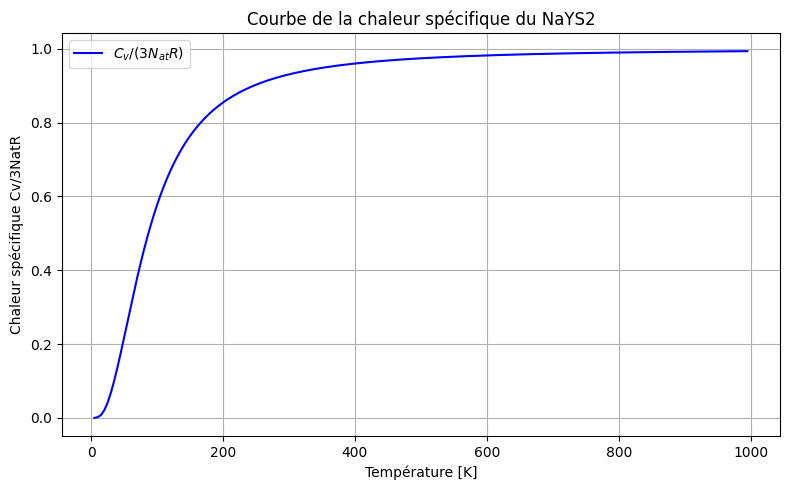

In [8]:
R = 8.314
temps = np.arange(5, 1000, 5)
Nat = len(prim_struc)  
ph_cv = np.array([ph_dos.cv(T) for T in temps])  # en J/mol·K

cv_norm = ph_cv / (3 * Nat * R)

plt.figure(figsize=(8, 5))
plt.plot(temps, cv_norm,color = 'blue', label=r"$C_v / (3N_{at}R)$")
plt.xlabel("Température [K]")
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.title('Courbe de la chaleur spécifique du NaYS2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Température d'Einstein optimale : 259 K


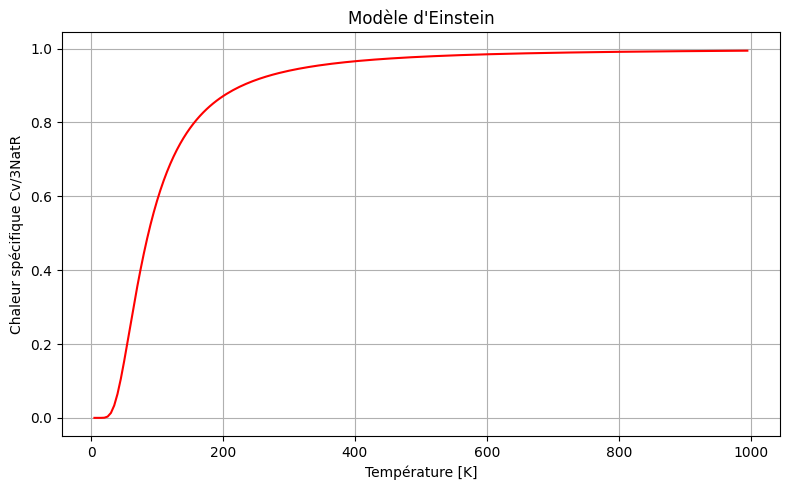

In [11]:
def cv_einstein(theta_E, T):
    if T == 0:
        return 0
    x = theta_E / T
    exp_x = np.exp(x)
    denom = exp_x - 1
    if denom == 0:
        return 0
    return (x**2 * exp_x) / (denom**2)  


def erreur_einstein(theta):
    erreur_totale = 0 
    for T, c_exp in zip(temps, cv_norm):
        cv_th = cv_einstein(theta, T)
        ecart_carre = (cv_th - c_exp)**2
        erreur_totale += ecart_carre
    return erreur_totale


theta_E_opt = min(range(1, 1000), key=erreur_einstein)
print("Température d'Einstein optimale :", theta_E_opt, "K")
cv_einstein_curve = [cv_einstein(theta_E_opt, T) for T in temps]


plt.figure(figsize=(8, 5))
plt.plot(temps, cv_einstein_curve, color='red')
plt.xlabel("Température [K]")
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.title("Modèle d'Einstein")
plt.grid(True)
plt.tight_layout()
plt.show()

Température de Debye optimale : 350 K


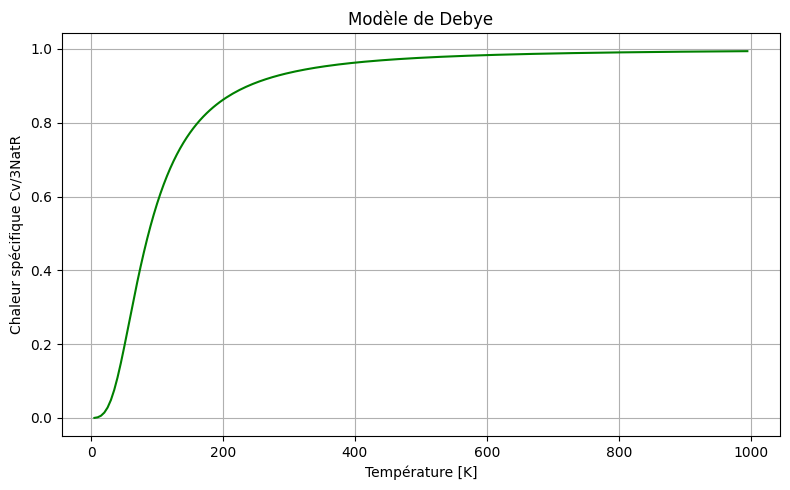

In [14]:
def integrand_debye(x):
    return (x**4 * np.exp(x)) / ((np.exp(x) - 1)**2)

def cv_debye(theta_D, T):
    if T == 0:
        return 0
    integral, _ = quad(integrand_debye, 0, theta_D / T)
    return 3 * (T / theta_D)**3 * integral  # normalisé

def erreur_debye(theta):
    erreur_totale = 0

    for i in range(len(temps)):
        T = temps[i]
        c_exp = cv_norm[i]

        c_th = cv_debye(theta, T)     
        ecart = c_th - c_exp        
        erreur_totale += ecart**2     

    return erreur_totale

theta_D_opt = min(range(1, 1000), key=erreur_debye)
print("Température de Debye optimale :", theta_D_opt, "K")
cv_debye_curve = [cv_debye(theta_D_opt, T) for T in temps]

plt.figure(figsize=(8, 5))
plt.plot(temps, cv_debye_curve, color='green')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.title("Modèle de Debye")
plt.grid(True)
plt.tight_layout()
plt.show()

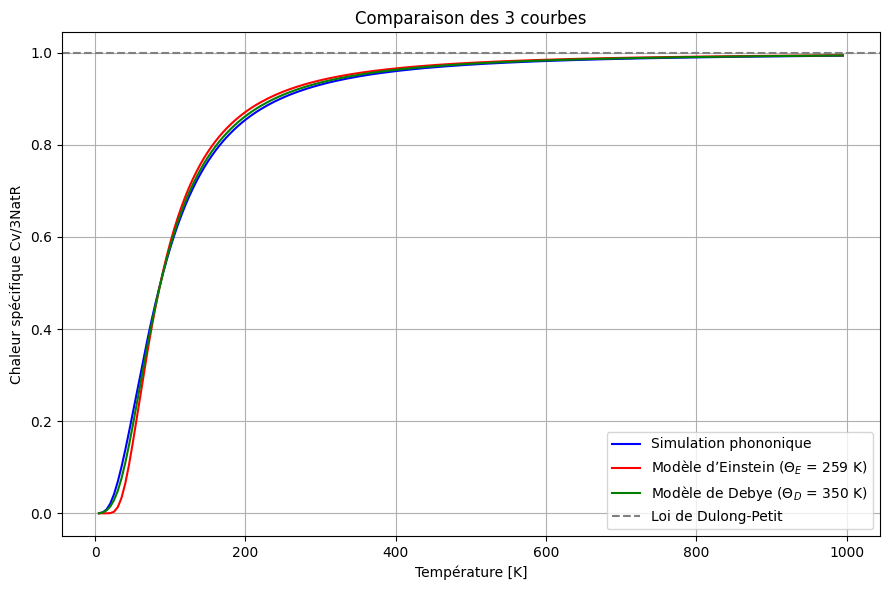

In [17]:
plt.figure(figsize=(9, 6))
plt.plot(temps, cv_norm, label="Simulation phononique", color='blue')
plt.plot(temps, cv_einstein_curve, label=fr"Modèle d’Einstein ($\Theta_E$ = {theta_E_opt} K)", color='red')
plt.plot(temps, cv_debye_curve, label=fr"Modèle de Debye ($\Theta_D$ = {theta_D_opt} K)", color='green')
plt.axhline(1.0, linestyle='--', color='gray', label="Loi de Dulong-Petit")
plt.xlabel("Température [K]")
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.title('Comparaison des 3 courbes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La fréquence de Debye vaut :  5.3944940543549285  [THz]
La fréquence d'Einstein vaut :  7.289856830209362 [THz]


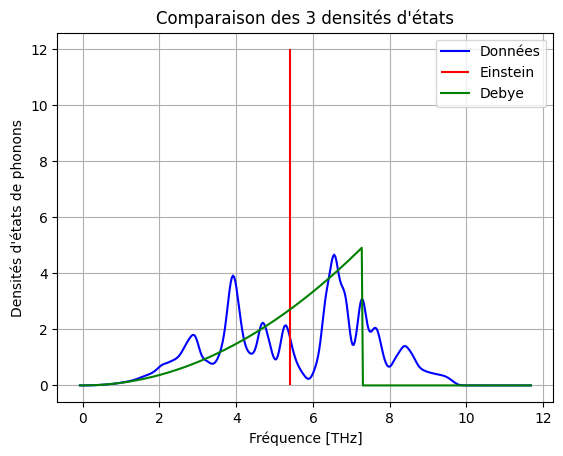

In [20]:
k_B = 1.380649e-23
conv_THz = 1e-12
h_barre = 1.055e-34

freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_e = conv_THz*k_B*theta_E_opt/h_barre
f_e = omega_e/(2*np.pi)

omega_d = conv_THz*k_B*theta_D_opt/h_barre
f_d = omega_d / (2 * np.pi)

dens_d = np.zeros(len(freq))
for i,f in enumerate(freq):
    omega = 2*np.pi*f
    if omega < omega_d:
        dens_d[i] = (9*Nat*(omega)**2/(omega_d**3))
        
print("\nLa fréquence de Debye vaut : ",f_e," [THz]")
print("La fréquence d'Einstein vaut : ",f_d,"[THz]")

plt.plot(freq, dens,color="blue", label="Données")
plt.vlines(f_e, 0, 3 * Nat ,color="red", label = "Einstein")
plt.plot(freq, dens_d*(2*np.pi), color='green', label="Debye")
plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence [THz]")
plt.legend()
plt.grid()
plt.show()
